In [1]:
%matplotlib inline 

import cv2
import numpy as np
from math import ceil, floor, gcd, log10, log
from typing import List, TextIO, Tuple
from matplotlib import pyplot as plt

In [2]:
def _skip_header(f: TextIO, skip_to_angles: int = 3) -> Tuple[int, int]:
    """Skip over the ies header and returns number of vertical and horizontal angles."""
    """    
    for line in f:
        if "TILT" in line : 
            f.readline()
            break

    line = f.readline()

    """    
    
    for _ in range(4):
        line = f.readline()
    
    angles = line.split(' ')
    angles_v, angles_h = int(angles[0]), int(angles[1])
    for _ in range(skip_to_angles):
        line = f.readline()
    return angles_v, angles_h


def _parse_angles(f: TextIO, angles: int) -> List[float]:
    """Parses angle part of ies and returns angle values.

    Args:
        f (TextIO): Opened IES file.
        angles (int): Number of angles to be read.

    Returns:
        List[float]: List of angle values.
    """
    line = f.readline()
    values = [float(value) for value in line.split(' ')]
    while len(values) < angles:
        line = f.readline()
        values += [float(value) for value in line.split(' ')]
    return values

In [3]:
def load_ies(path: str, skip_to_angles: int = 3) -> np.ndarray:
    """Loads ies into array.

    Args:
        path (str): Path to the ies file.
        skip_to_angles (int, optional): How many lines are going to be skipped to angles. Defaults to 3.

    Returns:
        np.ndarray: 2D array containing ies data. 
    """
    with open(path, 'r') as f:
        angles_v, angles_h = _skip_header(f, skip_to_angles)
        data = np.zeros(angles_h * angles_v, dtype=np.float32)
        values = _parse_angles(f, angles_v)
        values = _parse_angles(f, angles_h)

        i = 0
        line = f.readline()
        while line:
            values = [float(value) for value in line.split(' ')]
            data[i:i+len(values)] = values
            i += len(values)
            line = f.readline()
        data = data.reshape(angles_h, angles_v).T
        data = np.flipud(data)
        return data


In [4]:
def locate_angle_center(path: str, skip_to_angles: int = 3) -> np.ndarray:
    """Locate the center (0, 0) in ies file and returns its indicies.

    Args:
        path (str): Path to the ies file.
        skip_to_angles (int, optional): How many lines are going to be skipped to angles. Defaults to 3.

    Returns:
        np.ndarray: (y, x) coordinates of the (0, 0) center.
    """
    with open(path, 'r') as f:
        angles_v, angles_h = _skip_header(f, skip_to_angles)

        values = _parse_angles(f, angles_v)
        center_v_index = values.index(0)

        values = _parse_angles(f, angles_h)
        center_h_index = values.index(0)
        return np.array([center_v_index, center_h_index])

In [5]:
def compute_G(E, ies, centerX, centerY) -> float:
    value = ies[centerY, centerX - int(E / 0.1)] # 0.1 is step
    value01 = ies[centerY - 1, centerX - int(E / 0.1)] # one step to right
    G = (log10(value) - log10(value01))
    return G

def computeMaxGFromColumn(ies, column):
    height = int(ies.shape[0])
    maxG = -1.0
    maxGRow = -1
    
    for y in range(0, height - 1):
        valueUp = ies[y, column]
        valueDown = ies[y + 1, column]
        
        gradient = log10(valueDown) - log10(valueUp)
        
        if (gradient > maxG):
            maxG = gradient
            maxGRow = y

    return maxG, maxGRow

In [6]:
fileName = "VW270-LB-LEFT.ies"

ies = load_ies(fileName)

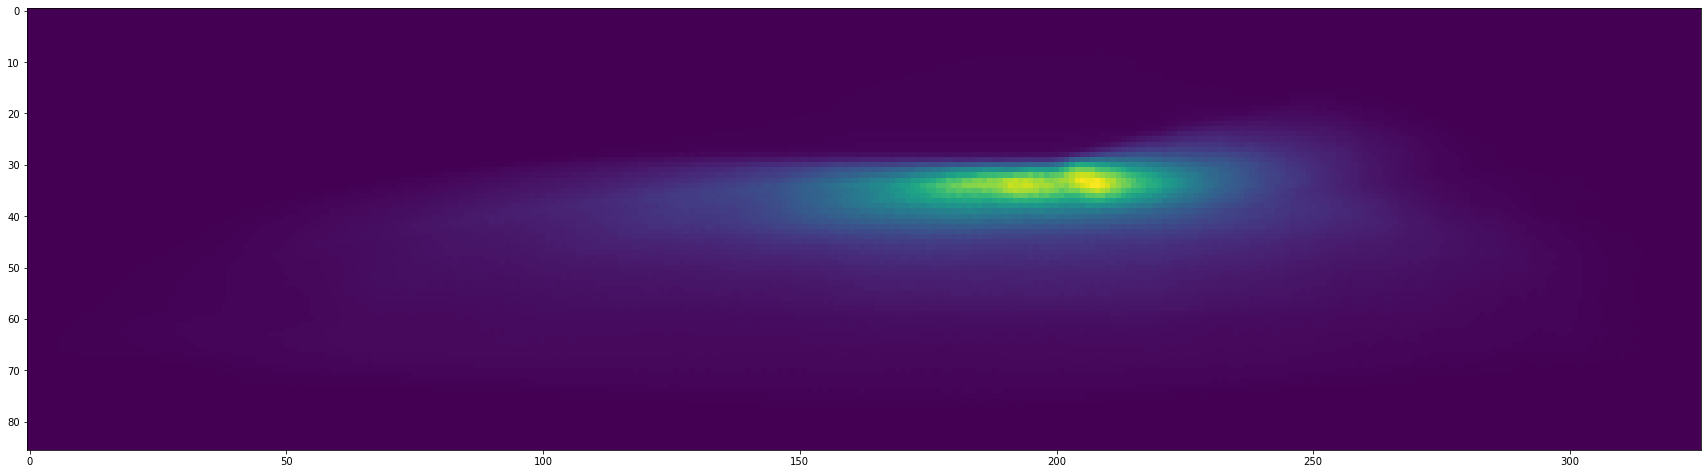

In [7]:
plt.figure(figsize=(30, 30))
plt.imshow(ies, interpolation='nearest')
plt.show()

In [8]:
# resize (bilinear) - final step 0.1
width = int(ies.shape[1] * 2)
height = int(ies.shape[0] * 2)
dim = (width, height)

ies = cv2.resize(ies, dim, interpolation = cv2.INTER_LINEAR)

centerY, centerX = locate_angle_center(fileName)
# center position multiplied by 2 because of the resize above
centerY = centerY * 2
centerX = centerX * 2

stepSize = 0.1 # 0.2 original, 0.1 after intetrpolation

#columns = [4.0, 3.0, 2.0, 1.0, 0.0]
columns = [1.5, 2.5, 3.5]
columnsInIES = [centerX - int(e / 0.1) for e in columns]

for x in columnsInIES:
    maxG, maxGRow = computeMaxGFromColumn(ies, x)
    print(maxG," - ", maxGRow);      

# colors for debug purposes
for x in range(0, width):
    maxG, maxGRow = computeMaxGFromColumn(ies, x)
    ies[maxGRow][x] = 100000;

0.23206759658408238  -  56
0.24343754547767116  -  56
0.2509029617570291  -  56
0.2714838749578634  -  56
0.25264053546486087  -  56


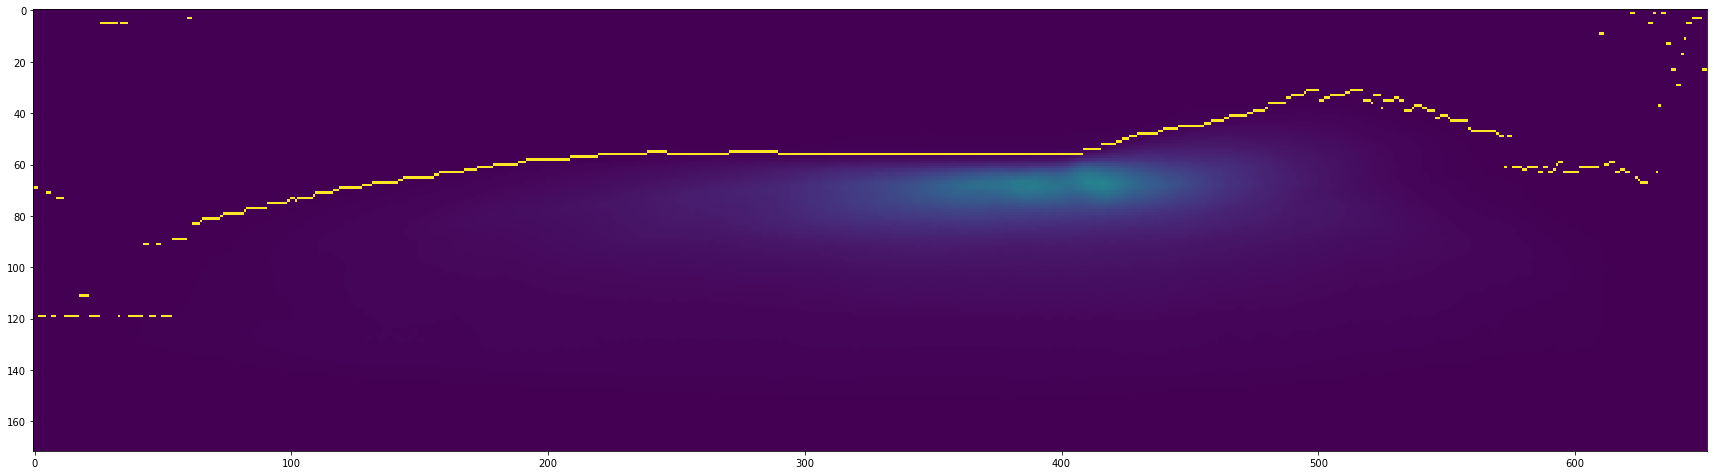

In [9]:
plt.figure(figsize=(30, 30))
plt.imshow(ies, interpolation='nearest')
plt.show()